# RNN Model For Classifying Tweets

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy.data import Field, TabularDataset, BucketIterator


import train_test_datasets as pdata
from lstm import LSTM
from evaluate import train_model, evaluate, load_checkpoint


In [2]:
# parameters
DATA_PATH = './data/tweets_all.csv'
SAVE_PATH = './data'

TEST_VALID_PERC=0.2
BATCH_SIZE = 32
MAX_SEQ_LEN = 150
BPTT_LENGTH = 64

EPOCHS = 5
LOSS_FN = nn.CrossEntropyLoss
OPTIM_FN = optim.Adam
HIDDEN_DIM = 150
LEARN_RATE = 0.001
DROP_OUT = 0.5
LAYERS = 2

In [3]:
# test and set kernel device
USE_CUDA = torch.cuda.is_available()

if USE_CUDA:
    DEVICE = torch.device('cuda')
    print("Using cuda.")
else:
    DEVICE = torch.device('cpu')
    print("Using cpu.")

Using cpu.


In [4]:
class_weights = pdata.make_data(DATA_PATH, SAVE_PATH, TEST_VALID_PERC)

# adding weights to loss function
class_weights.to(DEVICE)
LOSS_FN = LOSS_FN(weight=class_weights)

Datasets saved.
./data/train.csv saved; 10708 records
./data/valid.csv saved; 1190 records
./data/test.csv saved; 1322 records

checking class balance:
low in train:  5354
high in train:  5354


In [5]:
# Fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# TabularDataset
train, valid, test = TabularDataset.splits(path=SAVE_PATH, 
                                           train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=BATCH_SIZE, sort_key=lambda x: len(x.text),
                            device=DEVICE, sort=True, sort_within_batch=True)

# Vocabulary
text_field.build_vocab(train, min_freq=3)
print("vocab length: ", len(text_field.vocab))

/Users/LokiJo/opt/anaconda3/lib/python3.8/site-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


vocab length:  7655


In [6]:
model = LSTM(vocab_len=len(text_field.vocab),
             dropout=DROP_OUT,
             dimension=HIDDEN_DIM,
             layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(model.parameters(), lr=LEARN_RATE)

train_model(model=model,
            optimizer=optimizer,
            train_loader=train_iter,
            valid_loader=valid_iter,
            criterion = LOSS_FN,
            num_epochs = EPOCHS,
            file_path = SAVE_PATH,
            device=DEVICE)

Epoch [1/5], Step [167/1675], Train Loss: 0.7096, Valid Loss: 0.6781
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [1/5], Step [334/1675], Train Loss: 0.6416, Valid Loss: 0.6820
Epoch [2/5], Step [501/1675], Train Loss: 0.6572, Valid Loss: 0.6629
Model saved to ==> ./data/model.pt
Model saved to ==> ./data/metrics.pt
Epoch [2/5], Step [668/1675], Train Loss: 0.5663, Valid Loss: 0.6787
Epoch [3/5], Step [835/1675], Train Loss: 0.5927, Valid Loss: 0.6672
Epoch [3/5], Step [1002/1675], Train Loss: 0.4874, Valid Loss: 0.6769
Epoch [4/5], Step [1169/1675], Train Loss: 0.5392, Valid Loss: 0.6695
Epoch [4/5], Step [1336/1675], Train Loss: 0.4441, Valid Loss: 0.6887
Epoch [5/5], Step [1503/1675], Train Loss: 0.5091, Valid Loss: 0.6821
Epoch [5/5], Step [1670/1675], Train Loss: 0.4189, Valid Loss: 0.6915
Model saved to ==> ./data/metrics.pt
Finished Training!


Model loaded from <== ./data/model.pt
Test Accuracy:  0.6399394856278366
Classification Report:
              precision    recall  f1-score   support

           1     0.6448    0.6233    0.6338       661
           0     0.6354    0.6566    0.6458       661

    accuracy                         0.6399      1322
   macro avg     0.6401    0.6399    0.6398      1322
weighted avg     0.6401    0.6399    0.6398      1322



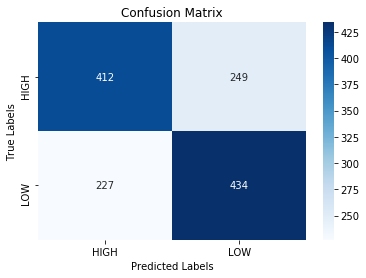

In [8]:
# Evaluate
best_model = LSTM(vocab_len=len(text_field.vocab),
                  dropout=DROP_OUT,
                  dimension=HIDDEN_DIM,
                  layers=LAYERS).to(DEVICE)

optimizer = OPTIM_FN(best_model.parameters(), lr=0.001)

load_checkpoint(SAVE_PATH + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)

## Feature importance

### Integrated gradient

In [19]:
from captum.attr import IntegratedGradients, LayerIntegratedGradients, TokenReferenceBase, visualization
from torchtext.data.utils import get_tokenizer
tokenizer = get_tokenizer('basic_english')

In [20]:
device = torch.device("cpu")
test = pd.read_csv('data/test.csv')
PAD_IDX = text_field.vocab.stoi['<pad>']
token_reference = TokenReferenceBase(reference_token_idx=PAD_IDX)

In [36]:
# accumalate couple samples in this array for visualization purposes
vis_data_records_ig = []

def int_gradient(text, max_len, true_label=0, target_label=0):
    #print(text)
    words = tokenizer(text)
    if len(words) < max_len:
        words += ['<pad>'] * (max_len - len(words))
    tokens = [text_field.vocab.stoi[w] for w in words]
    #print(tokens)
    
    best_model.zero_grad()
    input_indices = torch.tensor(tokens)
    input_indices = input_indices.unsqueeze(0)
    #print('input:', input_indices)
    
    # predict
    probs = best_model(input_indices, torch.tensor([max_len]))
    pred = torch.argmax(probs).item()
    pred_prob = probs.tolist()[0][pred]
    #print(probs)
    
    forward_func = lambda x: F.softmax(best_model(x,torch.tensor([max_len])), dim=-1)
    lig = LayerIntegratedGradients(forward_func, best_model.embedding)
    
    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(max_len, device=device).unsqueeze(0)
    #print(reference_indices)
    
    
    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices, \
                                           n_steps=500, target=target_label, return_convergence_delta=True)
    
    #print('pred: ', pred, '(', '%.2f'%pred_prob, ')', ', delta: ', abs(delta.tolist()[0]))    
    
    add_attributions_to_visualizer(attributions_ig, words, pred_prob, pred, true_label, delta, target_label, vis_data_records_ig)
    
    return attributions_ig.sum(dim=2).squeeze(0)

def add_attributions_to_visualizer(attributions, text, pred_prob, pred, label, delta, target, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()
    true_label = 'High' if int(label) == 1 else 'Low'
    pred_label = 'High' if int(pred) == 1 else 'Low'
    target_label = 'High' if int(target) == 1 else 'Low'
    
    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_label,
                            true_label,
                            target_label,
                            attributions.sum(),       
                            text,
                            delta))


In [41]:
words_importance = {}

for i in range(test.shape[0]):
    temp_numbers = int_gradient(test['text'][i],
                                len(tokenizer(test['text'][i])),
                                test['label'][i])
    temp_numbers = temp_numbers / torch.norm(temp_numbers)
    
    for n, w in enumerate(test.text[i].split()):
        if len(w) > 4:
            words_importance[w] = words_importance.get(w, 0.0) + temp_numbers[n]        

In [40]:
importance_df = pd.DataFrame.from_dict(words_importance, orient='index')
importance_df.sort_values(0).head(20)

0
trump     -64.102937
says      -30.131864
opinion   -22.311225
president -20.213824
trumps    -18.028256
with      -17.589058
analysis  -17.467227
police    -13.632999
china     -13.350255
after     -12.358074
over      -12.307168
house      -9.033713
court      -8.643477
border     -8.429998
violence   -8.309015
derek      -7.513411
were       -7.335623
breaking   -6.990353
myanmar    -6.971029
their      -6.903334

In [23]:
print('Visualize attributions based on Integrated Gradients')
_ = visualization.visualize_text(vis_data_records_ig)

Visualize attributions based on Integrated Gradients


In [13]:
test

label                                               text
0         0  beijing was shrouded in thick brown dust due t...
1         0  u s lawmakers plan legislation to overhaul aut...
2         0  norway prime minister fined by police over vir...
3         0  people will be allowed to move around downtown...
4         0  taiwan opposition chief in no rush for china m...
...     ...                                                ...
1155      1  ruttes prospects of forming new government wan...
1156      1  colorado rep boebert decries senseless violenc...
1157      1  the oscar contender promising young woman is a...
1158      1  japan has decided not to invite fans from abro...
1159      1  uae finance minister and dubai deputy ruler sh...

[1160 rows x 2 columns]